# Enunciado - Ej 4

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from scipy import stats
from urllib.request import urlopen
from collections import defaultdict

pwd = os.getcwd()

#### Funciones auxiliares

In [2]:
# Función auxiliar que devuelve un numpy array con todos los grados del grafo
get_degrees = lambda G: np.array([d for n, d in G.degree()])

def grado_vecinos(G):
    """
    INPUT: El grafo G.
    OUTPUT: Dos diccionarios, "grados" que contiene en valores a todos los grados de vecinos de un grado dado, y 
    "grado_med" es un diccionario con los grados como key y como valores el promedio de los grados de los vecinos
    de los nodos de esa key.
    """
    grados = defaultdict(list)
    grado_med = defaultdict()
    
    # En grados acumulamos los grados de todos los vecinos 
    for nodo, degree in G.degree():
        if G[nodo]:
            # Si tiene vecinos
            grados[degree] = grados[degree]+[d for n, d in G.degree(G[nodo])]
        else:
            pass
    
    for elem in grados.keys():
        grado_med[elem] = np.array(grados[elem]).mean()
    
    # Ploteamos
    plt.title('Promedio de grado de vecinos según el grado')
    plt.xlabel('Grados k')
    plt.ylabel('Knn(k)')
    plt.grid(True)
    plt.plot(pd.Series(grado_med))
    
    return grados, grado_med

In [3]:
def estimacion_potencia(G, dist_grado_medio):
    
    """
    INPUT: El grafo G y la distribución media de grado, un diccionario que devuelve la funcion grado_vecinos.
    OUTPUT: Devuelve el valor del log alfa y mu, y también plotea en escala logarítmica un scatter plot contra
    la regresión realizada, visualizando la varianza de los errores.
    """
    
    x = np.array(list(dist_grado_medio.keys()))
    y = np.array(list(dist_grado_medio.values()))
    datos = pd.DataFrame({'x':x, 'y':y})
    # Escalamos los valores
    x_log = np.log(datos.x)
    y_log = np.log(datos.y)
    
    # Calculamos el ajuste lineal
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x_log, y_log)
    
    # Ploteamos
    plt.subplots_adjust(wspace = 0.6)
    powerlaw = lambda a, mu, x: a*x**mu
    
    plt.subplot(121)
    plt.plot(pd.Series(dist_grado_medio),label='Knn(k)')
    x_aux = np.sort(np.array(list(dist_grado_medio.keys()))) 
    plt.plot(x_aux, powerlaw(np.exp(intercept), gradient, x_aux),label='Powerlaw estimada')
    plt.title('Distrubución de grado')
    plt.xlabel('Grados')
    plt.ylabel('Promedio de grado de vecinos')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.title('Distribución en escala logarítmica')
    sns.regplot(x = x_log, y = y_log)
    plt.xlabel('Log grados')
    plt.ylabel('Log promedio de grado de vecinos')
    plt.legend()
    
    return gradient, np.exp(intercept)

# Primer Item

In [4]:
# Carga de datos
colab_cient = nx.read_gml(pwd+'/Datos/netscience.gml')
red_internet = nx.read_gml(pwd+'/Datos/as-22july06.gml')

A continuación visualizamos como es la distribución media de los grados de los vecinos para los nodos de grados k tanto para la red de net_science y la red as-22july06, de tal forma que nos permita entender como es la asortividad de la red.

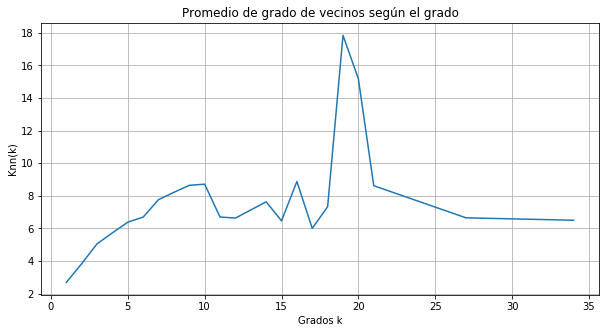

In [5]:
g1, grad_med_ciencia = grado_vecinos(colab_cient)

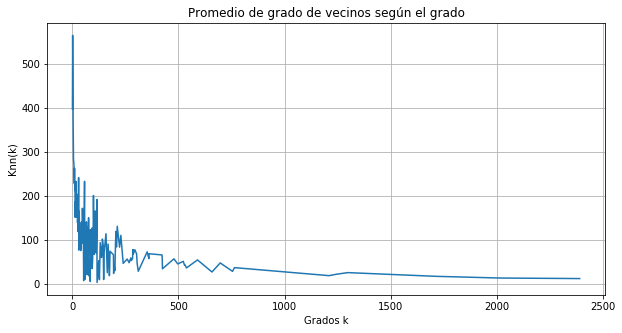

In [6]:
g2, grad_med_internet = grado_vecinos(red_internet)

Ahora realizamos un ajuste, suponiendo que el comportamiento de $k_{nn}(k)$ es el de una distribución powerlaw, es decir que $ k_{nn}(k) = \alpha  k^\mu $, entonces:

$\log(k_{nn}(k)) = \log(\alpha) + \mu \log(k)$

Y realizamos el ajuste lineal

(0.30611665100370722, 3.556824179716342)

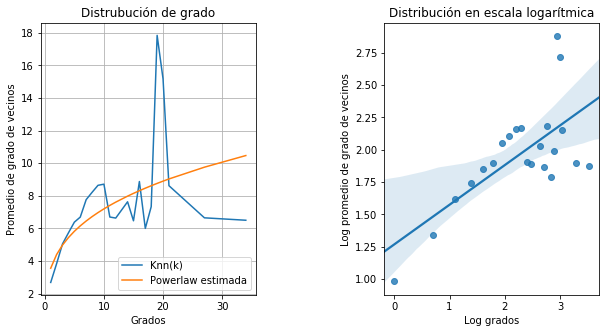

In [7]:
estimacion_potencia(colab_cient, grad_med_ciencia)

(-0.44417355167341699, 559.82540878019017)

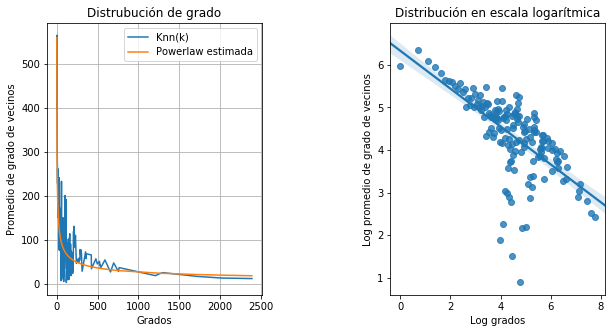

In [8]:
estimacion_potencia(red_internet, grad_med_internet)

### Asortatividad
Para calcular ahora si la asortatividad(disortatividad) de acuerdo al grado, vamos a usar la función de asortatividad para ver si los cálculos que obtenemos a mano coinciden con los cálculos del paquete NetworkX. Para calcularlo vamos a usar las fórmulas 8.27 - 8.29 del libro de Newman.

In [81]:
def asortatividad(G):
    """
    INPUT: La red G
    OUTPUT: El índice de asortatividad de Newman de la red G.
    """
    grados = get_degrees(G)
    
    # Calculamos los momentos
    S1 = grados.sum()
    S2 = (grados**2).sum()
    S3 = (grados**3).sum()
    
    S_e = 0
    for edge in G.edges():
        S_e += G.degree[edge[0]]*G.degree[edge[1]]
        
    r = (S1*2*S_e -S2**2)/(S1*S3 -S2**2)
    
    return r

def correlacion_grado(G, normalizado = False, robustez = True):
    """
    INPUT: La red G, si la co-ocurrencia es normalizada o no(default) y si el plot es robusto(default) o no.
    OUTPUT: Un gráfico de co-ocurrenncia entre los grados de la matriz no normalizado.
    Ref: https://networkx.github.io/documentation/stable/reference/algorithms/assortativity.html
    """
    m = nx.degree_mixing_matrix(G, normalized = normalizado)
    ax = sns.heatmap(m, cmap='YlGnBu', robust = robustez)
    ax.invert_yaxis()
    plt.show()
    
    return None

### Conclusiones - item a

#### Red de citaciones
En el caso de la red de internet, al observar el crecimiento de $k_{nn}$ con el grado hasta nodos de grado 15, muestra señales de una estructura asortativa, sin embargo para grados mayores, el comportamiento no es tan claro, relacionandose nodos de mayor grado(hubs) con todo tipo de nodos. Incluso el valor del ajuste de la distribución de grado de los vecinos, a pesar de la pendiente positiva del ajuste (potencia positiva), la cola de la distribución no parece estar bien ajustada por el modelo. Finalmente observando el valor del coeficiente de asortatividad, y la matriz de co-ocurrencias, viendo una mayor ocurrencia en la diagonal para los grados menores, coinciden con un comportamiento de la red asortativo, ya no es lo tan claro para valores mayores haciendo que la red tenga un comporamiento mixto.

In [10]:
asortatividad(colab_cient), nx.degree_assortativity_coefficient(colab_cient)

(0.4616224667525835, 0.46162246675258339)

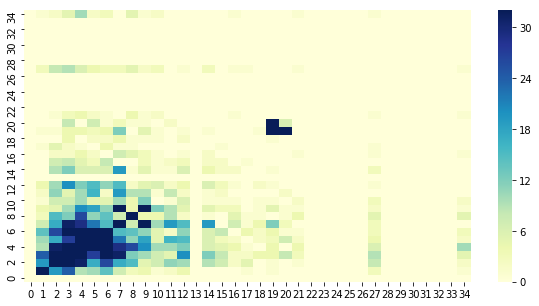

In [79]:
correlacion_grado(colab_cient)

#### Red de Internet
Esta red tiene un valor de asortatividad menor a la anterior, pareciendo tener en este caso un comportamiento disortativo, es decir que nodos de mayor grado prefieren evitar otros nodos de grado similar(hubs evitan hubs). Al visualizar el mapa de co-ocurrencias y la distribución de grado con su ajuste de potencia(el cual parece ser mucho mas robusto que en el caso anterior), observamos una clara estructura disortativa, sobretodo para grados mayores a 500, donde se puede ver como el promedio de grados es decreciente asi como el ajuste tiene una potencia negativa.

In [11]:
asortatividad(red_internet), nx.degree_assortativity_coefficient(red_internet)

(-0.19838487512056477, -0.19838487512056457)

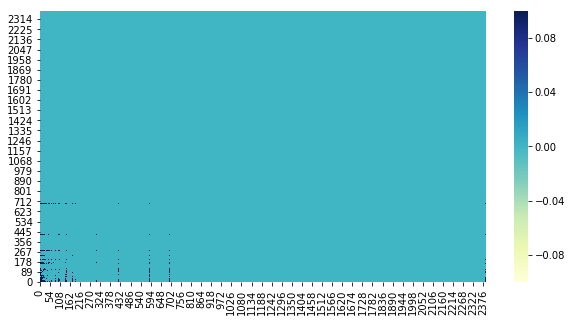

In [80]:
correlacion_grado(red_internet)

# Segundo Item

In [12]:
# Cargamos los datos
red_apms = nx.read_edgelist('Datos/yeast_AP-MS.txt')
red_y2h = nx.read_edgelist('Datos/yeast_Y2H.txt')

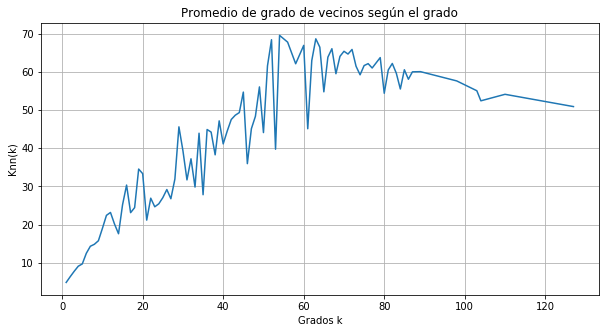

In [13]:
g3, grad_med_apms = grado_vecinos(red_apms)

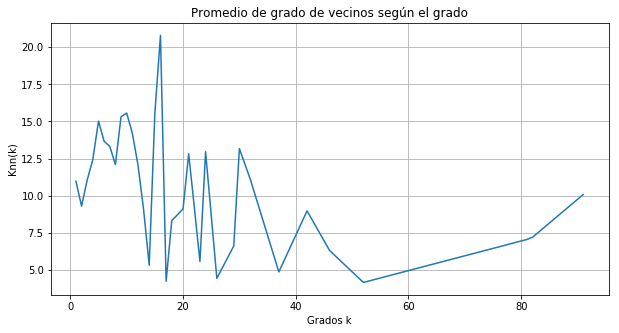

In [14]:
g4, grad_med_y2h = grado_vecinos(red_y2h)

#### Red AP_MS
En el caso de la red AP_MS, posee un alto valor del coeficiente de asortatividad lo que parece dar evidencias muy fuerte de una estructura asortativa de la red (es decir que los nodos de grados mayores parecen preferir conectarse con los nodos de grados similar). Al observar la distribución de grado, podemos ver una tendencia creciente, al igual que en la matriz de co-ocurrencias de los grados, observando mayor ocurrencia sobre la diagonal. El ajuste de potencia es positivo, y parece ser un buen ajuste, lo cual fortalece la evidencia de la asortatividad de la red.

In [17]:
asortatividad(red_apms)

0.60567421889444839

(0.59928923629801922, 4.538457131909853)

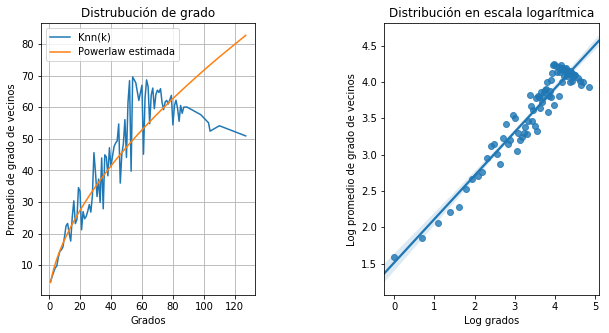

In [15]:
estimacion_potencia(red_apms, grad_med_apms)

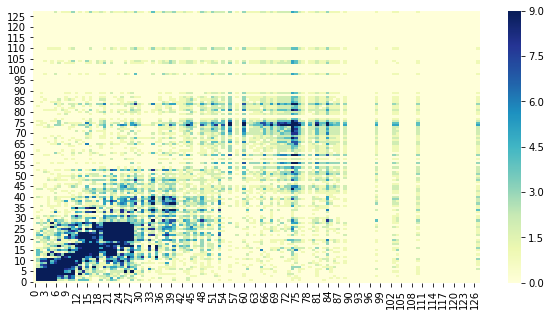

In [78]:
correlacion_grado(red_apms)

#### Red Y2H
Para el caso de la red Y2H se puede observar un comportamiento disortativo al observar el bajo valor del coeficiente de asortatividad. Esto coindice con lo que se puede apreciar tanto en la estructura del co-ocurrencia de los grados donde los nodos de mayor grado prefieren conectarse con nodos de grado menor y también en el ajuste de potencia. En este último se observa una gran variabilidad de la distribución del grado medio de los vecinos para los grados menores y luego una tendencia creciente pero el ajuste en sí no parece ser muy fiel a la distribución de los datos.

In [18]:
asortatividad(red_y2h)

-0.041067211172400114

(-0.17436816752067458, 15.434496844003091)

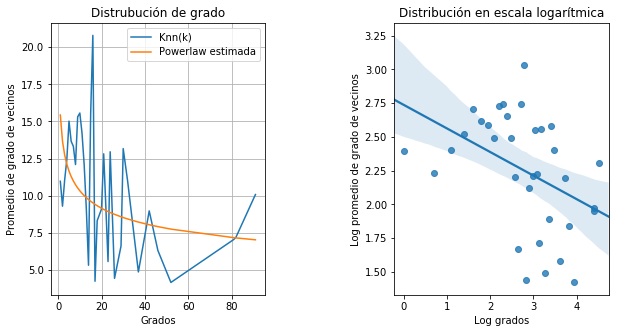

In [16]:
estimacion_potencia(red_y2h, grad_med_y2h)

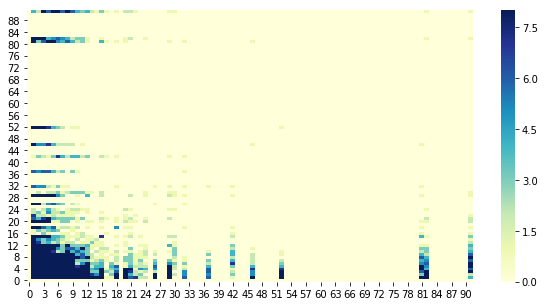

In [77]:
correlacion_grado(red_y2h)